In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from tqdm import tqdm

import eitest

# Data generators

In [2]:
@numba.njit
def event_series_bernoulli(series_length, event_count):
    '''Generate an iid Bernoulli distributed event series.

    series_length: length of the event series
    event_count: number of events'''

    event_series = np.zeros(series_length)
    event_series[np.random.choice(np.arange(0, series_length), event_count, replace=False)] = 1
    return event_series

@numba.njit
def time_series_mean_impact(event_series, order, signal_to_noise):
    '''Generate a time series with impacts in mean as described in the paper.

    The impact weights are sampled iid from N(0, signal_to_noise),
    and additional noise is sampled iid from N(0,1).
    
    event_series: input of shape (T,) with event occurrences
    order: order of the event impacts
    signal_to_noise: signal to noise ratio of the event impacts'''

    series_length = len(event_series)
    weights = np.random.randn(order)*np.sqrt(signal_to_noise)
    time_series = np.random.randn(series_length)
    for t in range(series_length):
        if event_series[t] == 1:
            time_series[t+1:t+order+1] += weights[:order-max(0, (t+order+1)-series_length)]
    return time_series

@numba.njit
def time_series_var_impact(event_series, delay, variance_increase):
    '''Generate a time series with impacts in variance as described in the paper.

    event_series: input of shape (T,) with event occurrences
    delay: delay of the event impacts
    variance_increase: signal to noise ratio of the event impacts'''

    series_length = len(event_series)
    time_series = np.random.randn(series_length)
    idx = np.where(event_series == 1)[0] + delay
    idx = idx[idx < series_length]
    time_series[idx] *= np.sqrt(1. + variance_increase)
    return time_series

@numba.njit
def time_series_tail_impact(event_series, delay, dof):
    '''Generate a time series with impacts in tails as described in the paper.

    event_series: input of shape (T,) with event occurrences
    order: order of the event impacts
    signal_to_noise: signal to noise ratio of the event impacts'''

    series_length = len(event_series)
    time_series = np.random.randn(series_length)*np.sqrt(dof/(dof-2))
    idx = np.where(event_series == 1)[0] + delay
    idx = idx[idx < series_length]
    time_series[idx] = np.random.standard_t(dof, size=len(idx))
    return time_series

# Visualization of the impact models

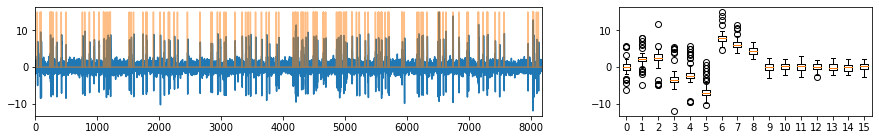

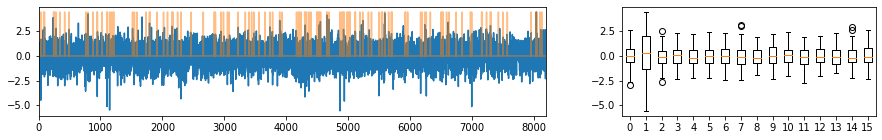

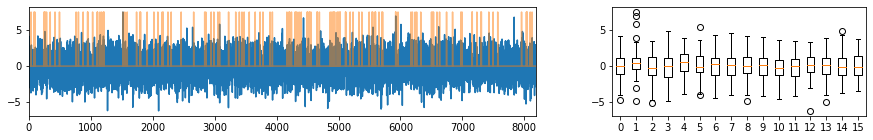

In [3]:
es = event_series_bernoulli(8192, 128)

for ts in [
    time_series_mean_impact(es, 8, 10.),
    time_series_var_impact(es, 1, 4.),
    time_series_tail_impact(es, 1, 3.)
]:
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(15, 2))
    ax1.plot(ts)
    ax1.plot(es*np.max(ts), alpha=0.5)
    ax1.set_xlim(0, len(es))
    samples = eitest.obtain_samples(es, ts, lag_cutoff=15, instantaneous=True)
    eitest.plot_samples(samples, ax2)
    plt.show()

# Simulations

In [4]:
def test_simul_pairs(impact_model, param_T, param_N, param_q, param_r,
                     n_pairs, lag_cutoff, instantaneous,
                     twosamp_test, multi_test, alpha):
    true_positive = 0.
    false_positive = 0.
    for _ in tqdm(range(n_pairs)):
        es = event_series_bernoulli(param_T, param_N)
        if impact_model == 'mean':
            ts = time_series_mean_impact(es, param_q, param_r)
        elif impact_model == 'var':
            ts = time_series_var_impact(es, param_q, param_r)
        elif impact_model == 'tail':
            ts = time_series_tail_impact(es, param_q, param_r)
        else:
            raise ValueError('impact_model must be "mean", "var" or "tail"')

        # coupled pair
        samples = eitest.obtain_samples(es, ts, lag_cutoff=lag_cutoff,
                                        instantaneous=instantaneous,
                                        sort=(twosamp_test == 'ks')) # samples need to be sorted for K-S test
        tstats, pvals = eitest.pairwise_twosample_tests(samples, twosamp_test, min_pts=2)
        pvals_adj = eitest.multitest(np.sort(pvals[~np.isnan(pvals)]), multi_test)
        true_positive += (pvals_adj.min() < alpha)

        # uncoupled pair
        samples = eitest.obtain_samples(np.random.permutation(es), ts, lag_cutoff=lag_cutoff,
                                        instantaneous=instantaneous,
                                        sort=(twosamp_test == 'ks'))
        tstats, pvals = eitest.pairwise_twosample_tests(samples, twosamp_test, min_pts=2)
        pvals_adj = eitest.multitest(np.sort(pvals[~np.isnan(pvals)]), multi_test)
        false_positive += (pvals_adj.min() < alpha)
        
    return true_positive/n_pairs, false_positive/n_pairs

In [5]:
# global parameters

default_T = 8192
n_pairs = 100
alpha = 0.05
twosamp_test = 'ks'
multi_test = 'simes'
lag_cutoff = 32
instantaneous = False

## Mean impact model

In [6]:
default_N = 128
default_r = 10.
default_q = 8

### ... by number of events

100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


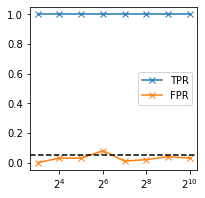

# mean impact model (T=8192, q=8, r=10.0, n_pairs=100, cutoff=32, instantaneous=False, alpha=0.05, ks-simes)
# N	tpr	fpr
8	1.0	0.0
16	1.0	0.03
32	1.0	0.03
64	1.0	0.08
128	1.0	0.01
256	1.0	0.02
512	1.0	0.04
1024	1.0	0.03


In [7]:
vals = [8, 16, 32, 64, 128, 256, 512, 1024]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='mean', param_T=default_T,
                                        param_N=val, param_q=default_q, param_r=default_r,
                                        n_pairs=n_pairs, lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.axhline(alpha, ls='--', c='black')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# mean impact model (T={default_T}, q={default_q}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {twosamp_test}-{multi_test})')
print(f'# N\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')

### ... by impact order

100%|██████████| 100/100 [00:01<00:00, 65.27it/s]


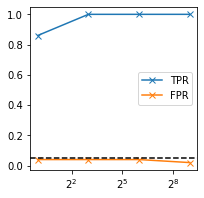

# mean impact model (T=8192, N=128, r=10.0, n_pairs=100, cutoff=32, instantaneous=False, alpha=0.05, ks-simes)
# q	tpr	fpr
1	0.86	0.04
8	1.0	0.04
64	1.0	0.04
512	1.0	0.02


In [8]:
vals = [1, 8, 64, 512]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='mean', param_T=default_T,
                                        param_N=default_N, param_q=val, param_r=default_r,
                                        n_pairs=n_pairs, lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.axhline(alpha, ls='--', c='black')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# mean impact model (T={default_T}, N={default_N}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {twosamp_test}-{multi_test})')
print(f'# q\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')

### ... by signal-to-noise ratio

100%|██████████| 100/100 [00:01<00:00, 74.20it/s]


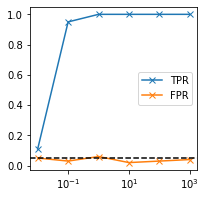

# mean impact model (T=8192, N=128, q=8, n_pairs=100, cutoff=32, instantaneous=False, alpha=0.05, ks-simes)
# r	tpr	fpr
0.01	0.11	0.05
0.1	0.95	0.03
1.0	1.0	0.06
10.0	1.0	0.02
100.0	1.0	0.03
1000.0	1.0	0.04


In [9]:
vals = [0.01, 0.1, 1., 10., 100., 1000.]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='mean', param_T=default_T,
                                        param_N=default_N, param_q=default_q, param_r=val,
                                        n_pairs=n_pairs, lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.axhline(alpha, ls='--', c='black')
plt.gca().set_xscale('log', base=10)
plt.legend()
plt.show()

print(f'# mean impact model (T={default_T}, N={default_N}, q={default_q}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {twosamp_test}-{multi_test})')
print(f'# r\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')

## Variance impact model

In [10]:
default_N = 128
default_r = 4.
default_q = 1

### ... by number of events

100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


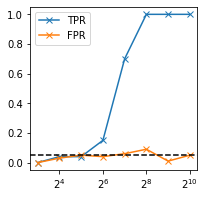

# var impact model (T=8192, q=1, r=4.0, n_pairs=100, cutoff=32, instantaneous=False, alpha=0.05, ks-simes)
# N	tpr	fpr
8	0.0	0.0
16	0.04	0.03
32	0.04	0.05
64	0.15	0.04
128	0.7	0.06
256	1.0	0.09
512	1.0	0.01
1024	1.0	0.05


In [11]:
vals = [8, 16, 32, 64, 128, 256, 512, 1024]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='var', param_T=default_T,
                                        param_N=val, param_q=default_q, param_r=default_r,
                                        n_pairs=n_pairs, lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.axhline(alpha, ls='--', c='black')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# var impact model (T={default_T}, q={default_q}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {twosamp_test}-{multi_test})')
print(f'# N\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')

### ... by variance increase

100%|██████████| 100/100 [00:01<00:00, 69.94it/s]


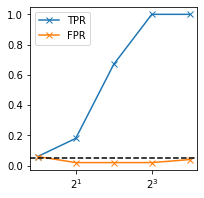

# var impact model (T=8192, N=128, q=1, n_pairs=100, cutoff=32, instantaneous=False, alpha=0.05, ks-simes)
# r	tpr	fpr
1.0	0.06	0.06
2.0	0.18	0.02
4.0	0.67	0.02
8.0	1.0	0.02
16.0	1.0	0.04


In [12]:
vals = [1., 2., 4., 8., 16.]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='var', param_T=default_T,
                                        param_N=default_N, param_q=default_q, param_r=val,
                                        n_pairs=n_pairs, lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.axhline(alpha, ls='--', c='black')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# var impact model (T={default_T}, N={default_N}, q={default_q}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {twosamp_test}-{multi_test})')
print(f'# r\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')

## Tail impact model

In [13]:
default_N = 1024
default_r = 3.
default_q = 1

### ... by number of events

100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


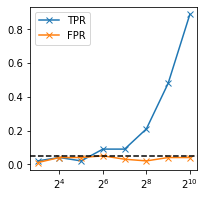

# var impact model (T=8192, q=1, r=3.0, n_pairs=100, cutoff=32, instantaneous=False, alpha=0.05, ks-simes)
# N	tpr	fpr
8	0.02	0.01
16	0.04	0.04
32	0.02	0.04
64	0.09	0.05
128	0.09	0.03
256	0.21	0.02
512	0.48	0.04
1024	0.89	0.04


In [14]:
vals = [8, 16, 32, 64, 128, 256, 512, 1024]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='tail', param_T=default_T,
                                        param_N=val, param_q=default_q, param_r=default_r,
                                        n_pairs=n_pairs, lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.axhline(alpha, ls='--', c='black')
plt.gca().set_xscale('log', base=2)
plt.legend()
plt.show()

print(f'# var impact model (T={default_T}, q={default_q}, r={default_r}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {twosamp_test}-{multi_test})')
print(f'# N\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')

### ... by degrees of freedom

100%|██████████| 100/100 [00:03<00:00, 26.56it/s]


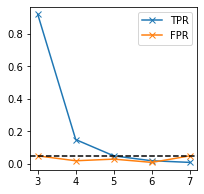

# var impact model (T=8192, N=1024, q=1, n_pairs=100, cutoff=32, instantaneous=False, alpha=0.05, ks-simes)
# r	tpr	fpr
3.0	0.92	0.05
4.0	0.15	0.02
5.0	0.05	0.03
6.0	0.02	0.01
7.0	0.01	0.05


In [15]:
vals = [3., 4., 5., 6., 7.]

tprs = np.empty(len(vals))
fprs = np.empty(len(vals))
for i, val in enumerate(vals):
    tprs[i], fprs[i] = test_simul_pairs(impact_model='tail', param_T=default_T,
                                        param_N=default_N, param_q=default_q, param_r=val,
                                        n_pairs=n_pairs, lag_cutoff=lag_cutoff, instantaneous=instantaneous,
                                        twosamp_test=twosamp_test, multi_test=multi_test, alpha=alpha)

plt.figure(figsize=(3,3))
plt.plot(vals, tprs, label='TPR', marker='x')
plt.plot(vals, fprs, label='FPR', marker='x')
plt.axhline(alpha, ls='--', c='black')
plt.legend()
plt.show()

print(f'# var impact model (T={default_T}, N={default_N}, q={default_q}, n_pairs={n_pairs}, cutoff={lag_cutoff}, instantaneous={instantaneous}, alpha={alpha}, {twosamp_test}-{multi_test})')
print(f'# r\ttpr\tfpr')
for i, (tpr, fpr) in enumerate(zip(tprs, fprs)):
    print(f'{vals[i]}\t{tpr}\t{fpr}')